In [1]:
import ROOT
from ROOT import TFile
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
import pandas as pd 
import time
from os import listdir

Welcome to JupyROOT 6.15/01


In [2]:
class particle:
    def __init__(self, pid, fourvector, virtual_photon):
        self.virtual_photon = virtual_photon #z-axis with respect to the lab
        Nu = virtual_photon.E()
        Q2 = -virtual_photon.M2()
        self.proton = ROOT.TLorentzVector()
        self.proton.SetPxPyPzE(0,0,0, 0.938)
        self.W = (virtual_photon + self.proton).M()
        incoming_e = ROOT.TLorentzVector()
        incoming_e.SetPxPyPzE(0,0,5.0,5.0)####INCONSISTENT
        part1 = virtual_photon.Vect().Cross(incoming_e.Vect()).Unit()
        part2 = virtual_photon.Vect().Cross(fourvector.Vect()).Unit()
        sign  = np.sign(part1.Dot(fourvector.Vect()))
        self.PhiPQ = sign*np.arccos(part1.Dot(part2))
        
        photon_pz = np.sqrt(Nu*Nu+Q2) #direction is positive by definition
        self.bcm = photon_pz/(Nu + 0.938)#photon-nucleon center-of-mass velocity 
        self.ycm = 0.5*np.log(( 1+self.bcm)/(1-self.bcm)) #photon-nucleon center-of-mass rapidity
        
        self.LorentzVector = fourvector #hadron four-vector
        self.PhiLab = self.LorentzVector.Phi()
        self.E = self.LorentzVector.E() #energy in lab frame
        self.vector = self.LorentzVector.Vect()
        self.Pt = self.vector.Perp(virtual_photon.Vect().Unit()) #pT with respect to photon direction
        self.Pl  = self.vector.Dot(virtual_photon.Vect().Unit()) #pL with respect to photon direction (in lab frame)
        self.y =  0.5*np.log( (self.E+self.Pl)/(self.E-self.Pl)) #rapidity in lab frame
        self.mT = np.sqrt(self.LorentzVector.M2() + self.Pt*self.Pt)
        self.y_star = self.y - self.ycm
        self.Pl_star = self.mT*np.sinh(self.y_star)
        self.Xf = 2.0*self.Pl_star/self.W 
        self.pid = pid
        self.Zh = self.E/Nu
        self.ThetaPQ = np.arctan(self.Pt/self.Pl)
        self.Xb = Q2/(2*0.938*Nu)

        
    def print_properties(self):
        print 'Hello, let me introduce myself, i am particle pid = ' , self.pid
        print 'zh = ', self.Zh, ' phi_pq= ', self.PhiPQ, ' theta_pq=' , self.ThetaPQ, 'E = ', self.E, ' xf', self.Xf,'Pt ', self.Pt, ' Pl= ', self.Pl, ' rapidity=' ,  self.y


In [3]:
class mytupla:
    def __init__(self):
        
        hadron_variables = ['pid','xf','z','y','ycm','pt','Q2','Xb','Nu','W','phi_pq','theta_pq',
                             'TargType','phi_lab','theta_lab','pos_x','pos_y','pos_z']
        
        self.tupla_hadron = {}
        for var in hadron_variables:
            self.tupla_hadron[var] = []    
            
            
        electron_variables = ['Q2','Xb','Nu','W','costheta']
        self.tupla_electron = {}
        for var in electron_variables:
            self.tupla_electron[var] = [] 

In [9]:

def getDataframes(filename, Target=1,maxevents=1e9,beamenergy=5.0):
    dphi = np.array([])
    ParticlesFromPrevious = []
    try:
        myfile = TFile.Open('%s'%filename,'READ')
    except:
        print("could not open file")

        
    myfile.Print()
    mytree = myfile.Get('RootTuple')
    
    print filename, ' has ', mytree.GetEntries(), ' entries'
    print 'The max number of events to be analyzes is ', maxevents
    df = mytupla()    
    
    start = time.time()
    for ievt  in range(mytree.GetEntries()):
        if(ievt%1e5==0):
            print 'Event # ', ievt
            end = time.time()
            print 'Processed in',  end-start, 'seconds'
            start = time.time()
        mytree.GetEntry(ievt)   
        if mytree.Q2<1.0: continue
        if ievt>maxevents: break
        Nu = mytree.nu
        Q2 = mytree.Q2
        phi_e = mytree.phiL 
        E    = beamenergy
        Eprime = E-Nu
        
        incoming_e = ROOT.TLorentzVector()
        incoming_e.SetPxPyPzE(0,0,E,E)
        
        #scattered electron
        scattered_e = ROOT.TLorentzVector()
        cos_thetae = 1-Q2/(2*E*Eprime)
        sin_thetae = np.sqrt(1-cos_thetae*cos_thetae)
        scattered_e.SetPxPyPzE(Eprime*sin_thetae*np.cos(phi_e),
                               Eprime*sin_thetae*np.sin(phi_e),
                               Eprime*cos_thetae,
                               Eprime)
        virtual_photon  = incoming_e - scattered_e
        virtual_photon_unitvector = virtual_photon.Vect().Unit()

        proton = ROOT.TLorentzVector()
        proton.SetPxPyPzE(0,0,0, 0.938)
        #print virtual_photon.M2(), ' ' , Q2
        #print virtual_photon.Vect().Mag(), ' ' , np.sqrt(Nu*Nu+Q2*Q2)
        
        #virtual_photon = ROOT.TLorentzVector()
        #virtual_photon.SetPxPyPzE( 0, 0, np.sqrt(Nu*Nu+Q2*Q2),Nu)  #lab frame but with z in photon direction 
        #cos_thetaphoton = E -Eprime
        
        #need to rotate to lab frame with z aligned with beam frame
        #virtual_photon.Rotate()
        #### virtual photon 
        #electron in lab frame = (0,0,E,E)
        #scattered electron in lab frame = (E'sintheta*cosphi,E'sintheta'sinphi,E'costheta,E')
        
        #Q2= 2EE'(1-cos_thetae)
        # cos_thetae =1- Q2/2EE'

        #photon in lab frame is e-e'
        # (-E'sintheta*cosphi, -E'sintheta*sinphi, E-E'costheta, E-E')
        
        #cos_thetaphoton = (E- E'*costheta)/(E-E')
        #cos_thetaphoton = (E- E'*(1- Q2/2EE'))/(E-E')
        #sin_thetaphoton = sqrt(1-cos_thetaphoton*cos_thetaphoton)
        #Thus, photon pT in lab frame with z-lepton direction is:
        #pT = E'sqrt(1-cos_thetaphoton^{2})
        #pT = E'sqrt(1- (E- E'*(1- Q2/2EE'))/(E-E')^{2} )
        #and finally, photon phi angle is:
        # phi_photon = -phi_electron (given)
        df.tupla_electron['Q2'].append(Q2)
        df.tupla_electron['Xb'].append(0)
        df.tupla_electron['Nu'].append(Nu)
        df.tupla_electron['W'].append(0)
        df.tupla_electron['costheta'].append(cos_thetae)
        
        for i in range(len(mytree.Px)):
            if abs(mytree.barcode[i]) !=211: continue
            i_lv = ROOT.TLorentzVector()    
            i_lv.SetPxPyPzE(mytree.Px[i],mytree.Py[i],mytree.Pz[i],mytree.E[i]) #with respect to photon direction
            i_part = particle(mytree.barcode[i], i_lv, virtual_photon)
            if i_part.Zh > 0.0:
                df.tupla_hadron['TargType'].append(999)
                df.tupla_hadron['pid'].append(i_part.pid)
                df.tupla_hadron['xf'].append(i_part.Xf)
                df.tupla_hadron['z'].append(i_part.Zh)
                df.tupla_hadron['y'].append(i_part.y_star)
                df.tupla_hadron['ycm'].append(i_part.ycm)
                df.tupla_hadron['pt'].append(i_part.LorentzVector.Pt())
                df.tupla_hadron['phi_pq'].append(i_part.PhiPQ)
                df.tupla_hadron['theta_pq'].append(i_part.ThetaPQ)
                df.tupla_hadron['Q2'].append(Q2)
                df.tupla_hadron['Xb'].append(i_part.Xb)
                df.tupla_hadron['Nu'].append(Nu)
                df.tupla_hadron['W'].append(i_part.W)
                df.tupla_hadron['phi_lab'].append(i_part.LorentzVector.Phi())
                df.tupla_hadron['theta_lab'].append(i_part.LorentzVector.Theta())
                df.tupla_hadron['pos_x'].append(mytree.x[i])
                df.tupla_hadron['pos_y'].append(mytree.y[i])
                df.tupla_hadron['pos_z'].append(mytree.z[i])
             
        
        
    end = time.time()
    print 'Processed in',  end-start, 'seconds'
    df_hadron = pd.DataFrame(df.tupla_hadron)
    df_electron = pd.DataFrame(df.tupla_electron)
    return df_electron,df_hadron

In [10]:
df = {}

## Configuration for CLAS6

In [11]:
nevents = 5e6
beamenergy = 5.0
df = {}

In [15]:
df['Pb_electron'], df['Pb_hadron'] = getDataframes('GiBUU/Lead/GiBUU_Pb.root',maxevents=1e7)

GiBUU/Lead/GiBUU_Pb.root  has  1800379  entries
The max number of events to be analyzes is  10000000.0
Event #  0
Processed in 0.0166640281677 seconds
Event #  100000
Processed in 76.8442020416 seconds
Event #  200000
Processed in 75.0241250992 seconds
Event #  300000
Processed in 75.404020071 seconds
Event #  400000
Processed in 75.9259080887 seconds
Event #  500000
Processed in 75.3598201275 seconds
Event #  600000
Processed in 75.4503898621 seconds
Event #  700000
Processed in 75.766397953 seconds
Event #  800000
Processed in 75.2667651176 seconds
Event #  900000
Processed in 75.4402060509 seconds
Event #  1000000
Processed in 76.1215639114 seconds
Event #  1100000
Processed in 75.5031979084 seconds
Event #  1200000
Processed in 75.7081418037 seconds
Event #  1300000
Processed in 75.565639019 seconds
Event #  1400000
Processed in 75.3575320244 seconds
Event #  1500000
Processed in 75.8173091412 seconds
Event #  1600000
Processed in 76.1493859291 seconds
Event #  1700000
Processed in

In [16]:
df['Fe_electron'], df['Fe_hadron'] = getDataframes('GiBUU/Iron/GiBUU_Fe.root',maxevents=1e7)

GiBUU/Iron/GiBUU_Fe.root  has  1852429  entries
The max number of events to be analyzes is  10000000.0
Event #  0
Processed in 0.0284481048584 seconds
Event #  100000
Processed in 73.1404750347 seconds
Event #  200000
Processed in 72.7579450607 seconds
Event #  300000
Processed in 72.7498219013 seconds
Event #  400000
Processed in 73.0303108692 seconds
Event #  500000
Processed in 73.157476902 seconds
Event #  600000
Processed in 73.1173689365 seconds
Event #  700000
Processed in 72.7584309578 seconds
Event #  800000
Processed in 72.8067429066 seconds
Event #  900000
Processed in 73.3212749958 seconds
Event #  1000000
Processed in 73.2256269455 seconds
Event #  1100000
Processed in 72.5408539772 seconds
Event #  1200000
Processed in 73.0758519173 seconds
Event #  1300000
Processed in 72.9796490669 seconds
Event #  1400000
Processed in 73.0039129257 seconds
Event #  1500000
Processed in 72.9062559605 seconds
Event #  1600000
Processed in 72.7935709953 seconds
Event #  1700000
Processed 

In [17]:
df['C_electron'], df['C_hadron'] = getDataframes('GiBUU/Carbon/GiBUU_C.root',maxevents=1e7)

GiBUU/Carbon/GiBUU_C.root  has  2566117  entries
The max number of events to be analyzes is  10000000.0
Event #  0
Processed in 0.033716917038 seconds
Event #  100000
Processed in 70.2186279297 seconds
Event #  200000
Processed in 69.7237439156 seconds
Event #  300000
Processed in 69.38331604 seconds
Event #  400000
Processed in 70.141438961 seconds
Event #  500000
Processed in 70.0391778946 seconds
Event #  600000
Processed in 69.3421230316 seconds
Event #  700000
Processed in 70.161755085 seconds
Event #  800000
Processed in 70.0224199295 seconds
Event #  900000
Processed in 69.4658420086 seconds
Event #  1000000
Processed in 69.8212461472 seconds
Event #  1100000
Processed in 69.65152812 seconds
Event #  1200000
Processed in 70.5661640167 seconds
Event #  1300000
Processed in 70.0741090775 seconds
Event #  1400000
Processed in 69.5899779797 seconds
Event #  1500000
Processed in 69.5457019806 seconds
Event #  1600000
Processed in 70.1451480389 seconds
Event #  1700000
Processed in 70

In [18]:
df['D_electron'], df['D_hadron'] = getDataframes('GiBUU/D/GiBUU_D.root',maxevents=1e7)

GiBUU/D/GiBUU_D.root  has  2458112  entries
The max number of events to be analyzes is  10000000.0
Event #  0
Processed in 0.0596828460693 seconds
Event #  100000
Processed in 64.8194980621 seconds
Event #  200000
Processed in 74.4536631107 seconds
Event #  300000
Processed in 98.1022372246 seconds
Event #  400000
Processed in 64.7440900803 seconds
Event #  500000
Processed in 64.5557539463 seconds
Event #  600000
Processed in 64.5460510254 seconds
Event #  700000
Processed in 64.3870680332 seconds
Event #  800000
Processed in 64.4218099117 seconds
Event #  900000
Processed in 64.2102029324 seconds
Event #  1000000
Processed in 64.1644339561 seconds
Event #  1100000
Processed in 64.4240131378 seconds
Event #  1200000
Processed in 64.2790250778 seconds
Event #  1300000
Processed in 64.5251970291 seconds
Event #  1400000
Processed in 64.5037689209 seconds
Event #  1500000
Processed in 64.3932387829 seconds
Event #  1600000
Processed in 64.753123045 seconds
Event #  1700000
Processed in 6

In [19]:
import root_pandas
from root_pandas import read_root
from root_pandas import to_root 

## Save dataframes to ROOT files

In [20]:
to_root(df['D_electron'],'GiBUU_SingleHadron_D.root', key='D_electron')
to_root(df['D_hadron'],'GiBUU_SingleHadron_D.root', key='D_hadron', mode='a')

In [21]:
to_root(df['C_electron'],'GiBUU_SingleHadron_C.root', key='C_electron')
to_root(df['C_hadron'],'GiBUU_SingleHadron_C.root', key='C_hadron', mode='a')

In [22]:
to_root(df['Fe_electron'],'GiBUU_SingleHadron_Fe.root', key='Fe_electron')
to_root(df['Fe_hadron'],'GiBUU_SingleHadron_Fe.root', key='Fe_hadron', mode='a')

In [23]:
to_root(df['Pb_electron'],'GiBUU_SingleHadron_Pb.root', key='Pb_electron')
to_root(df['Pb_hadron'],'GiBUU_SingleHadron_Pb.root', key='Pb_hadron', mode='a')

## Check simulated data

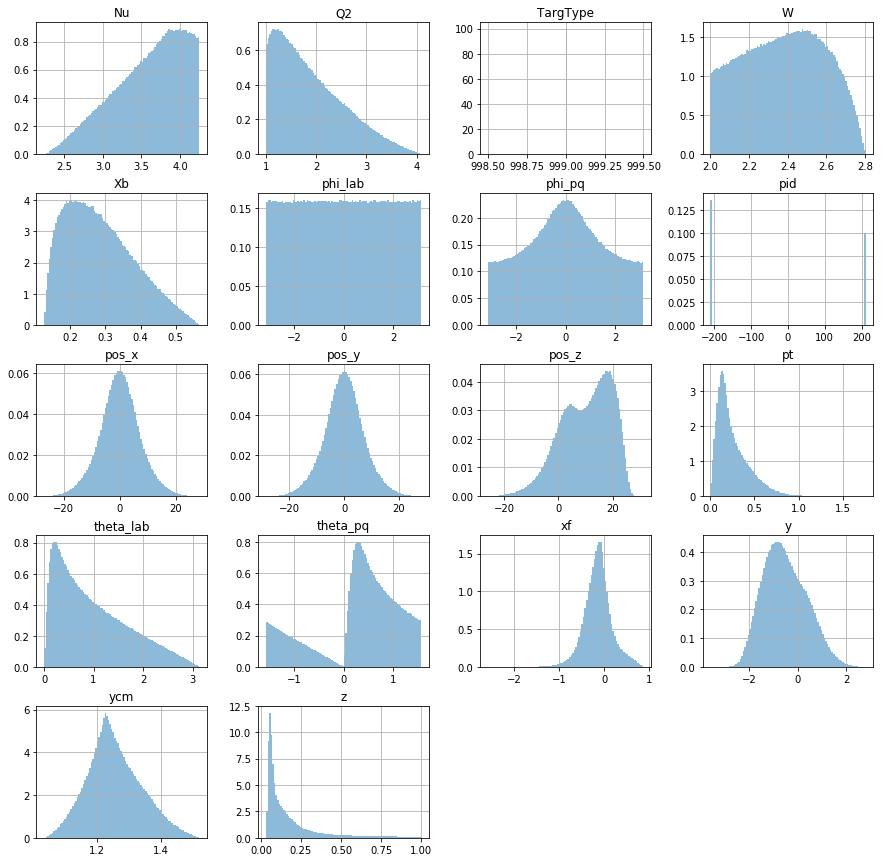

In [24]:
df['Pb_hadron'].hist(figsize=(15, 15),normed=True,alpha=0.5,bins=100)
plt.show()

In [ ]:
df['Fe'].hist(figsize=(15, 15),normed=True,alpha=0.5,bins=100)
plt.show()

In [ ]:
df['D'].hist(figsize=(15, 15),normed=True,alpha=0.5,bins=20)

plt.show()

In [ ]:
D_electrons = df['D'].query('Q2>1.0 and Q2<4.0').shape[0]
y_D, x  = np.histogram(df['D_trigger'].query('Q2>1.0 and Q2<4.0')['z'],bins=15,range=(0.1,0.9))

denominator = np.true_divide(y_D,D_electrons)

for nuclei in ['C','Fe','Pb']:
    A_electrons = df[nuclei].query('Q2>1.0 and Q2<4.0').shape[0]
    y_A, x  = np.histogram(df['%s_trigger'%nuclei].query('Q2>1.0 and Q2<4.0')['z'],bins=15,range=(0.1,0.9))
    x = (x[1:] + x[:-1])/2.0

    numerator = np.true_divide(y_A,A_electrons)
    ratio = np.divide(numerator, denominator)
    plt.errorbar(x, ratio, marker='o')

plt.show()

In [ ]:
print y_D
print y_Fe
print D_electrons
print Fe_electrons
print np.divide(y_D,D_electrons)
print np.divide(y_Fe,Fe_electrons)

In [ ]:

denominator = np.divide(y_D,D_electrons)
numerator = np.divide(y_Fe,Fe_electrons)
ratio = np.divide(numerator, denominator)
plt.errorbar(x, ratio, marker='o')

plt.ylim([0.2,1.4])
plt.show()

In [ ]:
y_D, x , _  = plt.hist(df['D'].query('Q2>1.5 and Q2<2.0')['Xb'],bins=5,range=(0.1,0.7),normed=True,alpha=0.7,label='D')
y_Fe, x , _  = plt.hist(df['Fe'].query('Q2>1.5 and Q2<2.0')['Xb'],bins=5,range=(0.1,0.7),normed=True,alpha=0.7,label='Fe')
x = (x[1:] + x[:-1])/2.0


In [ ]:
plt.errorbar(x, y_D, marker='o')
plt.errorbar(x, y_Fe, marker='o')


In [ ]:
plt.errorbar(x, np.divide(y_Fe, y_D), marker='o')

